# Montly DACON Machine Fault Diagnosis
## -  Anomaly Detection

## Library Import

In [1]:
# ! pip install librosa

In [1]:
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

C:\Users\user\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [4]:
train_df = pd.read_csv('./train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./test.csv')

In [5]:
train_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


In [6]:
train_df['LABEL'].unique()

array([0], dtype=int64)

In [7]:
train_df['FAN_TYPE'].unique()

array([2, 0], dtype=int64)

In [8]:
train_label = train_df[['FAN_TYPE','LABEL']]
train_label

,FAN_TYPE,LABEL
0,2,0
1,0,0
2,0,0
3,2,0
4,2,0
...,...,...
1274,2,0
1275,2,0
1276,2,0
1277,2,0


In [9]:
test_df

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./test/TEST_0000.wav,2
1,TEST_0001,./test/TEST_0001.wav,2
2,TEST_0002,./test/TEST_0002.wav,0
3,TEST_0003,./test/TEST_0003.wav,0
4,TEST_0004,./test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./test/TEST_1509.wav,0
1510,TEST_1510,./test/TEST_1510.wav,2
1511,TEST_1511,./test/TEST_1511.wav,0
1512,TEST_1512,./test/TEST_1512.wav,0


In [10]:
id_test = test_df['SAMPLE_ID']
id_test

0       TEST_0000
1       TEST_0001
2       TEST_0002
3       TEST_0003
4       TEST_0004
          ...    
1509    TEST_1509
1510    TEST_1510
1511    TEST_1511
1512    TEST_1512
1513    TEST_1513
Name: SAMPLE_ID, Length: 1514, dtype: object

In [11]:
test_fan = test_df['FAN_TYPE']
test_fan

0       2
1       2
2       0
3       0
4       0
       ..
1509    0
1510    2
1511    0
1512    0
1513    2
Name: FAN_TYPE, Length: 1514, dtype: int64

In [12]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    return features

In [13]:
train_features = get_mfcc_feature(train_df)
test_features = get_mfcc_feature(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

## EDA

In [14]:
train_features = pd.DataFrame(train_features)
train_features

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-332.822968,96.714211,-14.923254,21.968349,-8.564011,-2.027139,-11.869203,3.885383,-5.751901,3.539212,...,0.539370,0.663468,0.523915,-0.309365,-0.818508,-0.129562,0.530418,0.116271,-0.800855,-0.867277
1,-438.514435,142.282898,-2.122107,30.592234,0.737141,15.533081,-2.803471,4.224413,-1.894261,3.574962,...,0.178568,-0.044237,0.042868,0.374269,0.762829,0.738473,0.288381,0.002098,0.344611,0.157145
2,-419.292419,123.302338,10.127716,21.659258,-1.092546,11.255920,-3.392200,1.564470,3.889135,3.802192,...,0.462635,0.319143,0.199252,0.078277,0.520589,0.860090,0.382899,-0.062304,-0.115386,-0.302028
3,-333.860535,97.461487,-13.956150,22.239994,-9.348626,-2.875100,-11.314520,6.395192,-2.481325,3.891461,...,0.078985,0.460926,-0.021310,0.223788,-0.586876,-0.260907,-0.127186,0.113592,-0.935072,-0.169548
4,-333.146606,90.000252,-21.705933,14.738313,-18.315388,-9.914182,-16.343977,2.563049,-6.700718,-0.878550,...,0.055402,0.145842,-0.031247,0.558820,-0.543790,-0.374026,-0.223215,0.091165,-0.612550,-0.216652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-331.278717,83.516144,-24.639460,17.099073,-17.417219,-9.260210,-16.640516,-0.968224,-8.006652,-0.210976,...,-0.178437,-0.041334,-0.172667,-0.083145,-0.373329,0.001631,-0.215286,-0.068310,-0.687748,-0.080964
1275,-331.944550,96.614929,-15.033259,22.885084,-9.548154,-3.824131,-13.007987,5.053965,-3.507394,4.024566,...,0.308821,0.210678,0.629672,0.535989,-0.188029,-0.090514,0.081146,0.165999,0.017817,-0.548864
1276,-335.417572,92.459663,-19.939020,14.659498,-14.785932,-6.819523,-14.032730,1.931983,-8.374944,0.402798,...,-0.494620,-0.082534,0.327789,0.258334,-0.339538,-0.661168,-0.750548,-0.497419,-0.981389,-1.050707
1277,-335.176880,94.095650,-16.676874,17.122639,-13.769090,-7.083161,-12.534894,5.114513,-4.965012,0.256115,...,-0.174318,-0.098888,-0.008657,-0.311247,-0.878406,-0.427334,-0.186461,-0.092595,-0.752961,-0.147661


In [15]:
test_features = pd.DataFrame(test_features)
test_features

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-337.466980,93.499161,-14.531839,18.782629,-12.993633,-8.891464,-15.007888,2.987521,-4.080492,3.411654,...,0.164154,0.485381,0.375715,0.610794,0.073637,0.207322,0.096070,0.408414,-0.723793,-0.071414
1,-336.332123,98.042473,-14.108411,22.853271,-10.276470,-4.724311,-13.290108,5.331754,-3.047695,3.999879,...,0.103364,0.016831,0.042590,0.843998,0.041890,0.020773,-0.281918,0.173492,-0.634122,0.104590
2,-411.103058,146.174515,-9.374091,28.873428,-3.150095,14.049159,-3.056240,6.908220,-0.042742,4.407775,...,0.780984,0.600820,0.476922,0.563234,0.534703,0.684900,0.188768,0.328292,0.420767,-0.095793
3,-432.922638,149.789581,17.103008,15.994091,11.349452,14.492430,4.636677,7.593799,-0.623311,6.458681,...,0.816981,0.770491,0.940058,0.350600,0.109936,0.470496,0.976864,-1.214070,-1.232217,-0.899378
4,-421.299835,147.652374,-8.984773,27.868708,-2.585596,14.579635,-2.599407,6.154584,-1.616731,5.772117,...,0.392530,0.168321,-0.095196,0.534444,0.721170,1.066953,0.719139,0.225388,-0.045223,-0.460058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,-433.645569,149.396683,15.755504,13.032167,12.392975,16.820803,6.094834,5.686713,-0.725644,6.116574,...,1.001100,1.318711,0.423131,-0.261257,0.159387,0.486768,1.015050,-0.103403,0.325985,0.371032
1510,-400.652466,128.039993,7.505565,9.477396,-8.824609,3.085480,-6.793148,3.817405,-2.430128,-0.906629,...,-0.419314,0.330574,-0.324109,0.174071,-0.162394,-0.051136,0.150210,-0.030394,-0.762911,0.062789
1511,-425.808594,140.022720,-5.812835,33.935928,-1.197876,15.227143,-4.239627,4.924495,-3.108877,4.950401,...,-0.119929,0.302331,0.258988,0.435238,0.395255,0.415199,-0.006936,0.052725,0.278880,0.126119
1512,-428.836456,142.657898,-6.374496,33.241409,-2.003935,14.646495,-4.510120,4.902259,-3.379752,5.055974,...,0.076547,0.336713,0.479046,0.773435,0.756806,0.699998,-0.015126,-0.232445,0.278983,0.515977


In [16]:
train_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,...,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,-377.995148,113.071587,-8.204121,23.844816,-5.696002,3.985400,-7.830544,4.918558,-3.314722,3.504721,...,0.234378,0.325420,0.187519,0.239336,-0.007590,0.230924,0.119021,0.099486,-0.224045,-0.076919
std,44.433617,20.116034,9.127360,6.379835,6.397071,9.715972,6.013824,1.850644,2.243773,1.990546,...,0.370404,0.429256,0.347362,0.349561,0.543606,0.440418,0.372824,0.358652,0.549388,0.402612
min,-448.470551,76.786301,-32.213192,9.417195,-18.516598,-11.760926,-20.303896,-5.875247,-12.201679,-1.488135,...,-0.919933,-0.801145,-1.379041,-1.058502,-1.417813,-0.976136,-0.999907,-1.490106,-1.982088,-1.442499
25%,-422.757462,96.079597,-15.300093,18.211164,-10.590346,-4.679994,-13.268520,4.101818,-4.322296,2.457698,...,0.033521,0.043346,-0.041060,0.003929,-0.397619,-0.090389,-0.130518,-0.058163,-0.623901,-0.332300
50%,-340.757111,98.747040,-12.232296,22.529514,-7.863924,-0.741084,-10.262085,5.039417,-3.339386,3.758240,...,0.193546,0.251227,0.190680,0.269571,-0.067489,0.200933,0.075717,0.133931,-0.311153,-0.044135
75%,-334.778168,133.674660,0.087004,30.151427,0.304949,14.362323,-2.352551,5.795192,-2.380331,4.778134,...,0.373254,0.543552,0.408663,0.505621,0.435155,0.543489,0.325567,0.316944,0.255672,0.183964
max,-327.026825,146.801788,26.229727,43.937645,9.320457,21.310450,5.242990,14.517347,6.673819,15.678002,...,1.999650,2.045654,1.464702,1.327185,1.503646,1.570143,1.681078,1.487185,1.195769,1.074005


In [21]:
# train data 스케일링
from sklearn import preprocessing

cols = train_features.columns
scaler = preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(train_features)

train_features_scale = pd.DataFrame(np_scaled, columns = cols)
train_features_scale

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.952273,0.284621,0.295843,0.363586,0.357530,0.294327,0.330165,0.478636,0.341701,0.292864,...,0.499833,0.514477,0.669173,0.314013,0.205139,0.332475,0.570807,0.539543,0.371707,0.228580
1,0.081981,0.935459,0.514880,0.613406,0.691659,0.825306,0.685032,0.495261,0.546074,0.294947,...,0.376253,0.265880,0.500013,0.600570,0.746422,0.673378,0.480528,0.501195,0.732160,0.635661
2,0.240260,0.664368,0.724483,0.354632,0.625930,0.695975,0.661987,0.364824,0.852471,0.308184,...,0.473550,0.393526,0.555005,0.476499,0.663505,0.721141,0.515783,0.479564,0.587409,0.453196
3,0.943729,0.295295,0.312391,0.371455,0.329344,0.268686,0.351878,0.601711,0.514972,0.313384,...,0.342144,0.443330,0.477445,0.537493,0.284425,0.280892,0.325523,0.538643,0.329472,0.505841
4,0.949608,0.188729,0.179787,0.154144,0.007228,0.055841,0.155006,0.413792,0.291434,0.035511,...,0.334067,0.332650,0.473951,0.677927,0.299174,0.236467,0.289704,0.531110,0.430963,0.487123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.964989,0.096119,0.129592,0.222531,0.039493,0.075616,0.143398,0.240628,0.222247,0.074400,...,0.253973,0.266900,0.424220,0.408837,0.357521,0.383998,0.292662,0.477547,0.407300,0.541042
1275,0.959506,0.283203,0.293961,0.390142,0.322176,0.239990,0.285589,0.535940,0.460612,0.321138,...,0.420866,0.355425,0.706362,0.668357,0.420948,0.347810,0.403230,0.556246,0.629325,0.355110
1276,0.930908,0.223856,0.210020,0.151861,0.134018,0.149416,0.245477,0.382846,0.202736,0.110155,...,0.145676,0.252428,0.600205,0.551973,0.369088,0.123697,0.093010,0.333419,0.314898,0.155689
1277,0.932890,0.247222,0.265837,0.223214,0.170546,0.141445,0.304108,0.538909,0.383390,0.101610,...,0.255384,0.246683,0.481895,0.313224,0.184636,0.215531,0.303413,0.469390,0.386779,0.514538


In [25]:
# total train
tot_train = pd.concat([train_features_scale,train_label],axis=1)
tot_train

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,FAN_TYPE,LABEL
0,0.952273,0.284621,0.295843,0.363586,0.357530,0.294327,0.330165,0.478636,0.341701,0.292864,...,0.669173,0.314013,0.205139,0.332475,0.570807,0.539543,0.371707,0.228580,2,0
1,0.081981,0.935459,0.514880,0.613406,0.691659,0.825306,0.685032,0.495261,0.546074,0.294947,...,0.500013,0.600570,0.746422,0.673378,0.480528,0.501195,0.732160,0.635661,0,0
2,0.240260,0.664368,0.724483,0.354632,0.625930,0.695975,0.661987,0.364824,0.852471,0.308184,...,0.555005,0.476499,0.663505,0.721141,0.515783,0.479564,0.587409,0.453196,0,0
3,0.943729,0.295295,0.312391,0.371455,0.329344,0.268686,0.351878,0.601711,0.514972,0.313384,...,0.477445,0.537493,0.284425,0.280892,0.325523,0.538643,0.329472,0.505841,2,0
4,0.949608,0.188729,0.179787,0.154144,0.007228,0.055841,0.155006,0.413792,0.291434,0.035511,...,0.473951,0.677927,0.299174,0.236467,0.289704,0.531110,0.430963,0.487123,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.964989,0.096119,0.129592,0.222531,0.039493,0.075616,0.143398,0.240628,0.222247,0.074400,...,0.424220,0.408837,0.357521,0.383998,0.292662,0.477547,0.407300,0.541042,2,0
1275,0.959506,0.283203,0.293961,0.390142,0.322176,0.239990,0.285589,0.535940,0.460612,0.321138,...,0.706362,0.668357,0.420948,0.347810,0.403230,0.556246,0.629325,0.355110,2,0
1276,0.930908,0.223856,0.210020,0.151861,0.134018,0.149416,0.245477,0.382846,0.202736,0.110155,...,0.600205,0.551973,0.369088,0.123697,0.093010,0.333419,0.314898,0.155689,2,0
1277,0.932890,0.247222,0.265837,0.223214,0.170546,0.141445,0.304108,0.538909,0.383390,0.101610,...,0.481895,0.313224,0.184636,0.215531,0.303413,0.469390,0.386779,0.514538,2,0


In [26]:
# PCA
from sklearn.decomposition import PCA

y = tot_train['LABEL']
X = tot_train.loc[:, tot_train.columns != 'LABEL']

pca = PCA(n_components = 2)
pca_df = pca.fit_transform(X)
df_p = pd.DataFrame(data = pca_df, columns = ['pca1', 'pca2'])

fdf = pd.concat([df_p, y], axis = 1)

pca.explained_variance_ratio_

array([0.60158733, 0.04956715])

Text(0, 0.5, 'Principal Components 2')

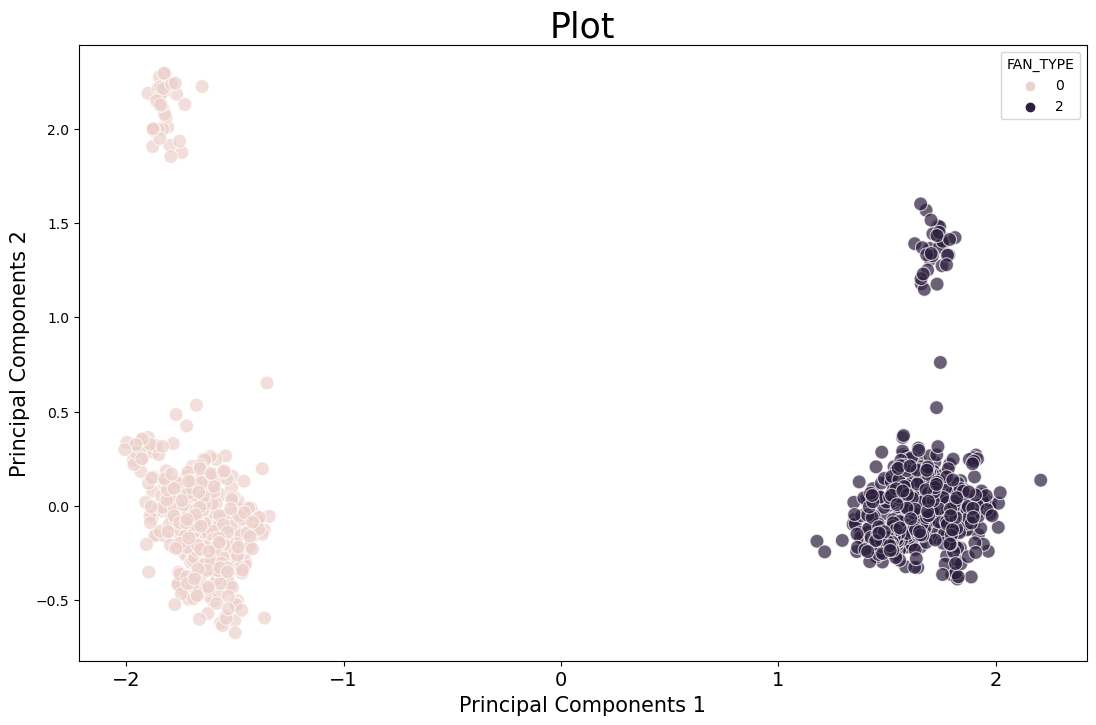

In [27]:
plt.figure(figsize= (13,8))
sns.scatterplot(x = 'pca1', y = 'pca2', data = fdf, hue = tot_train['FAN_TYPE'], alpha = 0.7,
               s = 100)

plt.title('Plot', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10)
plt.xlabel("Principal Components 1", fontsize = 15)
plt.ylabel("Principal Components 2", fontsize = 15)

In [56]:
from sklearn.cluster import KMeans

k = 4

def kmeans_cluster(data, n):
    km_tt_model = KMeans(n_clusters=n, algorithm='auto', 
                         random_state=np.random.RandomState(seed=CFG['SEED'])) # 군집 label 고정
    km_tt_model.fit(data)  # 학습 
    predict_list = km_tt_model.predict(data)  # clustering
    return

In [57]:
kmeans_cluster(df_p, k)

df_p['cluster'] = model.fit_predict(df_p)

In [58]:
df_p

,pca1,pca2,cluster
0,1.571527,0.035321,1
1,-1.644479,-0.195613,0
2,-1.542452,0.264267,0
3,1.552068,0.081969,1
4,1.837858,0.133177,1
...,...,...,...
1274,1.875462,0.073376,1
1275,1.410203,-0.243134,1
1276,1.665509,1.229534,3
1277,1.726328,0.113308,1


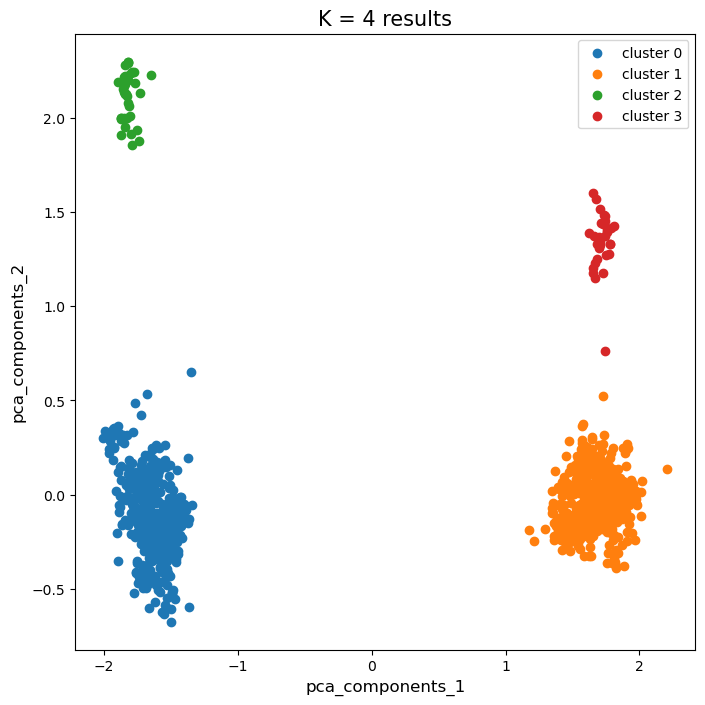

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df_p.loc[df_p['cluster'] == i, 'pca1'], 
                df_p.loc[df_p['cluster'] == i, 'pca2'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('pca_components_1', size = 12)
plt.ylabel('pca_components_2', size = 12)
plt.show()

In [50]:
# Cluster 2랑 3이 이상치.

In [66]:
clust['LABEL'] = pd.DataFrame(df_p['cluster'])
clust

,cluster,LABEL
0,0,1
1,0,0
2,0,0
3,0,1
4,0,1
...,...,...
1274,0,1
1275,0,1
1276,1,3
1277,0,1


In [67]:
clust = clust["LABEL"].replace([0,1,2,3],[0,0,1,1])
clust

0       0
1       0
2       0
3       0
4       0
       ..
1274    0
1275    0
1276    1
1277    0
1278    0
Name: LABEL, Length: 1279, dtype: int32

In [68]:
# train Data 에 붙이기
train_end = pd.concat([train_features,clust],axis=1)
train_end

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,LABEL
0,-332.822968,96.714211,-14.923254,21.968349,-8.564011,-2.027139,-11.869203,3.885383,-5.751901,3.539212,...,0.663468,0.523915,-0.309365,-0.818508,-0.129562,0.530418,0.116271,-0.800855,-0.867277,0
1,-438.514435,142.282898,-2.122107,30.592234,0.737141,15.533081,-2.803471,4.224413,-1.894261,3.574962,...,-0.044237,0.042868,0.374269,0.762829,0.738473,0.288381,0.002098,0.344611,0.157145,0
2,-419.292419,123.302338,10.127716,21.659258,-1.092546,11.255920,-3.392200,1.564470,3.889135,3.802192,...,0.319143,0.199252,0.078277,0.520589,0.860090,0.382899,-0.062304,-0.115386,-0.302028,0
3,-333.860535,97.461487,-13.956150,22.239994,-9.348626,-2.875100,-11.314520,6.395192,-2.481325,3.891461,...,0.460926,-0.021310,0.223788,-0.586876,-0.260907,-0.127186,0.113592,-0.935072,-0.169548,0
4,-333.146606,90.000252,-21.705933,14.738313,-18.315388,-9.914182,-16.343977,2.563049,-6.700718,-0.878550,...,0.145842,-0.031247,0.558820,-0.543790,-0.374026,-0.223215,0.091165,-0.612550,-0.216652,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-331.278717,83.516144,-24.639460,17.099073,-17.417219,-9.260210,-16.640516,-0.968224,-8.006652,-0.210976,...,-0.041334,-0.172667,-0.083145,-0.373329,0.001631,-0.215286,-0.068310,-0.687748,-0.080964,0
1275,-331.944550,96.614929,-15.033259,22.885084,-9.548154,-3.824131,-13.007987,5.053965,-3.507394,4.024566,...,0.210678,0.629672,0.535989,-0.188029,-0.090514,0.081146,0.165999,0.017817,-0.548864,0
1276,-335.417572,92.459663,-19.939020,14.659498,-14.785932,-6.819523,-14.032730,1.931983,-8.374944,0.402798,...,-0.082534,0.327789,0.258334,-0.339538,-0.661168,-0.750548,-0.497419,-0.981389,-1.050707,1
1277,-335.176880,94.095650,-16.676874,17.122639,-13.769090,-7.083161,-12.534894,5.114513,-4.965012,0.256115,...,-0.098888,-0.008657,-0.311247,-0.878406,-0.427334,-0.186461,-0.092595,-0.752961,-0.147661,0


In [71]:
X_train = train_end.loc[:, 0:127]
y_train = train_end['LABEL']

In [73]:
X_test = test_features

## Modeling 
### - XGBoost Modeling

In [75]:
from xgboost import XGBClassifier, plot_importance

model = XGBClassifier(colsample_bytree= 0.8, gamma= 1, learning_rate=0.15, 
                      max_depth =  10, n_estimators= 100)
                                   
model.fit(x_train, y_train)

y_pred = model.predict(X_test)

y_pred

array([0, 0, 0, ..., 0, 0, 1])

# Submission

In [76]:
submit = pd.read_csv('./sample_submission.csv')
submit

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
1509,TEST_1509,0
1510,TEST_1510,0
1511,TEST_1511,0
1512,TEST_1512,0


In [77]:
submit['LABEL'] = y_pred
submit

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,0
...,...,...
1509,TEST_1509,0
1510,TEST_1510,0
1511,TEST_1511,0
1512,TEST_1512,0


In [78]:
submit.to_csv('./submit_cluster.csv', index=False)